In [1]:
# Process json heart rate files
# Usually one activity per file, and creates a dataframe per activity
# Heart rates with low confidence are not included in the dataframe
# If there are no high confidence heart rates, the dataframe is not used

# The process checks that there are no long periods with no activity in the dataframe
# If there is such a period, a new activity dataframe after the silent period is created

# The process also removes short activities 

# reset_indexing of the dataframe is used often to prevent warrnings, see:
# http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [2]:
# Settings for high/low confidence, long silent period, short time activity

confidnece_limit = 1  #0, 1 - low confidence; 2,3 - high confidence
silent_time_limit = "20 minutes"
short_time_limit = "5 minutes"

In [3]:
import glob
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Functions

In [4]:
def processHeartRate(df):
    
    df['Date'] = pd.to_datetime(df['dateTime']).dt.date
    df['Time'] = pd.to_datetime(df['dateTime']).dt.time
    
    # Copying the dict values to the dataframe, based on:
    # https://stackoverflow.com/questions/29681906/python-pandas-dataframe-from-series-of-dict
    
    temp_df = pd.DataFrame(list(df['value']))
    df['BPM']=temp_df['bpm']
    df['Confidence']=temp_df['confidence']
 
    # Cleans the data frame from low confidence heart rates
    # The if clause prevents removing all items and returning an empty df
    # The dfExists flag indicates that there is no valid dataframe
    # The reset_index create a new continuos index starting with zero   
     
    dfTemp=df[df[:]['Confidence']>confidnece_limit]
    
    if len(dfTemp)>1:
        dfExists=True
        dfNew=dfTemp.reset_index(drop=True)
    else:
        #print('File with only low confidnece readings',df.iloc[0]['Date'],end=' ')
        dfExists=False
        dfNew=df
    
    return dfExists, dfNew

In [5]:
def calculateSummery(df):
    
    Date=df.iloc[0]['Date'] # Assumes a single date along the dataframe
    Duration= datetime.combine( Date, df['Time'].max() ) - datetime.combine( Date,df['Time'].min() )
    MeanBPM=round(df['BPM'].mean(),0)
    MaxBPM=round(df['BPM'].max(),0)
    String= str(df.iloc[0]['Date']) + ' ' + str(Duration) + ' ' + str(MeanBPM)   
    Summary = {'string': String, 'date': Date, 'meanBPM': MeanBPM, 'maxBPM': MaxBPM, 'duration':Duration}

    return Summary

In [6]:
# Each json heart rate file covers a day; this function identifies days with more than one activity
# Uses a hurisitc, that there is no data for more than 20 minutes, to divide into a new activity

def identifySilentTime(df):
    
    breakExists=False
    j=0
    for i in range(len(df)-1):
        delta=df.iloc[i+1]['dateTime'] - df.iloc[i]['dateTime']
        if (delta>pd.Timedelta(silent_time_limit)):
            #print('BREAK ',i,df.iloc[i]['Time'],df.iloc[i+1]['Time'])
            breakExists=True
            j=i
            break
    return breakExists,j

# Main: Process

In [7]:
start=0           # File number to start from 
end=293           # Process and plot n files

In [8]:
files=glob.glob("FITBIT\heart_rate*.json")

filesToRead=files[start:end]
print('files',len(files),'start',start,'end',end, 'files to read',len(filesToRead))

files 293 start 0 end 293 files to read 293


In [9]:
DFs=[]
Summaries=[]

print('Process monitoring, file numbers: - standard df, / time break dfs, no df *')
readNewFile=True
i=0
while (i< len(filesToRead)) or (not readNewFile): 
        
    if (readNewFile):
        df0=pd.read_json(filesToRead[i])
        i+=1 # Next file 
        
    dfExists, df = processHeartRate(df0)
    
    if (dfExists):
                
        breakExists,breakIndex=identifySilentTime(df)
        if (breakExists):
            df1=df[0:breakIndex+1]
            df0=df[breakIndex+1:].reset_index(drop=True)
            readNewFile=False
            print(i-1,end='/')
        else: # (NOT breakExists)
            df1=df
            readNewFile=True
            print(i-1,end='-')
        # IF (breakExists) ends
        
        DFs.append(df1)
        summary = calculateSummery(df1)
        Summaries.append(summary)
    
    else: # (NOT dfExists)
        print(i-1,end='*')
        readNewFile=True
    # IF (dfExists) ends
    
# WHILE ends 
print('\nlen(DFs),len(Summaries)',len(DFs),len(Summaries))

Process monitoring, file numbers: - standard df, / time break dfs, no df *
0-1/1/1-2/2/2-3/3/3/3-4-5-6/6-7/7-8/8-9-10/10-11-12-13-14/14-15/15-16-17-18-19-20-21-22-23/23-24-25-26/26-27-28-29-30-31/31-32-33/33-34-35-36/36-37-38-39-40/40-41/41/41-42-43/43/43-44-45-46-47-48-49-50-51-52/52*53*54-55-56-57-58-59*60/60-61-62-63-64-65-66-67-68-69-70-71/71-72-73/73-74/74-75/75/75/75-76-77-78-79/79-80-81/81-82-83/83*84-85-86-87/87-88-89-90-91*92/92/92-93-94*95/95-96-97-98-99-100/100-101/101-102*103/103-104-105*106*107*108*109*110-111/111-112/112/112-113-114-115-116/116-117-118/118-119-120-121*122/122/122-123-124/124-125-126-127-128-129/129-130*131-132*133*134-135*136/136/136-137*138*139-140/140-141*142-143*144-145*146*147-148-149-150-151-152/152-153*154-155*156-157-158-159-160*161-162*163-164*165/165-166/166-167*168-169/169-170*171-172-173-174-175-176-177/177-178-179/179-180-181-182-183/183/183-184-185-186-187-188/188-189/189-190-191-192-193-194/194-195-196-197-198-199-200-201-202-203-204*205*206

In [10]:
# Remove short sequences

for idx, d in enumerate(Summaries):
    delta=d['duration']
    if (delta<pd.Timedelta(short_time_limit)):
        print(idx,end=' ')
        del Summaries[idx]
print('\n Summaries',len(Summaries))

for idx, df in enumerate(DFs):
    Date=df.iloc[0]['Date']
    delta=datetime.combine( Date, df['Time'].max() ) - datetime.combine( Date,df['Time'].min() )
    if (delta<pd.Timedelta(short_time_limit)):
        print(idx,end=' ')
        del DFs[idx]
print('\n DFs',len(DFs))

2724435556588789105112126139147155157178196226268274292317323
 Summaries 325
2724435556588789105112126139147155157178196226268274292317323
 DFs 325


In [11]:
import pickle

pickle.dump(DFs, open('DFs.pkl', 'wb'))
pickle.dump(Summaries, open('Summaries.pkl', 'wb'))

# Plot Activity Summaries

C:\Users\yossi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


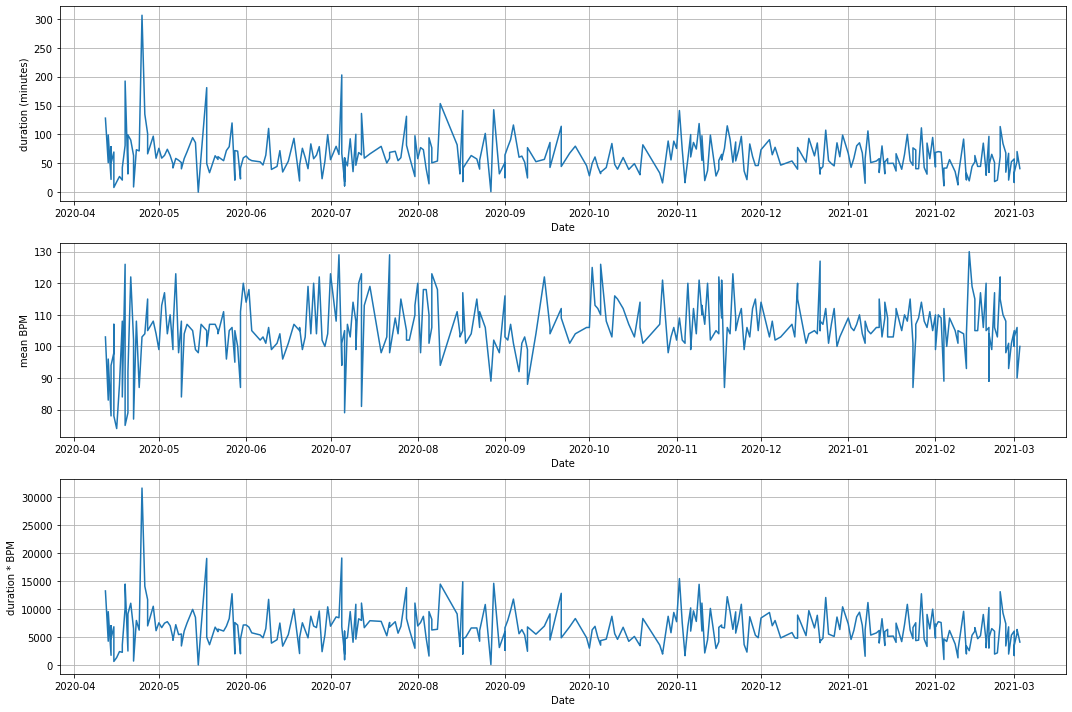

In [12]:
import numpy as np

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 10) )

x=[d['date'] for d in Summaries]

y1=[d['duration'].total_seconds()/60 for d in Summaries]
axs[0].plot(x,y1)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('duration (minutes)')
axs[0].grid(True)
#axs[i].xaxis.set_major_formatter(myFormat)

y2=[d['meanBPM'] for d in Summaries]
axs[1].plot(x,y2)
axs[1].set_xlabel('Date')
axs[1].set_ylabel('mean BPM')
axs[1].grid(True)

y3=np.asarray(y1)*np.asarray(y2)
axs[2].plot(x,y3)
axs[2].set_xlabel('Date')
axs[2].set_ylabel('duration * BPM')
axs[2].grid(True)            

fig.tight_layout()
plt.show()

# Plot Heart Rates

In [17]:
# Plot only a few of the detailed heart rate sequences

start1=300        # Uses the file numbers from the cell above
end1=325            # but can be changed

DFs=pickle.load(open('DFs.pkl', 'rb'))
Summaries=pickle.load(open('Summaries.pkl', 'rb'))

DFs=DFs[start1:end1]
Summaries=Summaries[start1:end1]
nPlots=len(DFs)
print(len(DFs),len(Summaries))

25 25


nPlots 25


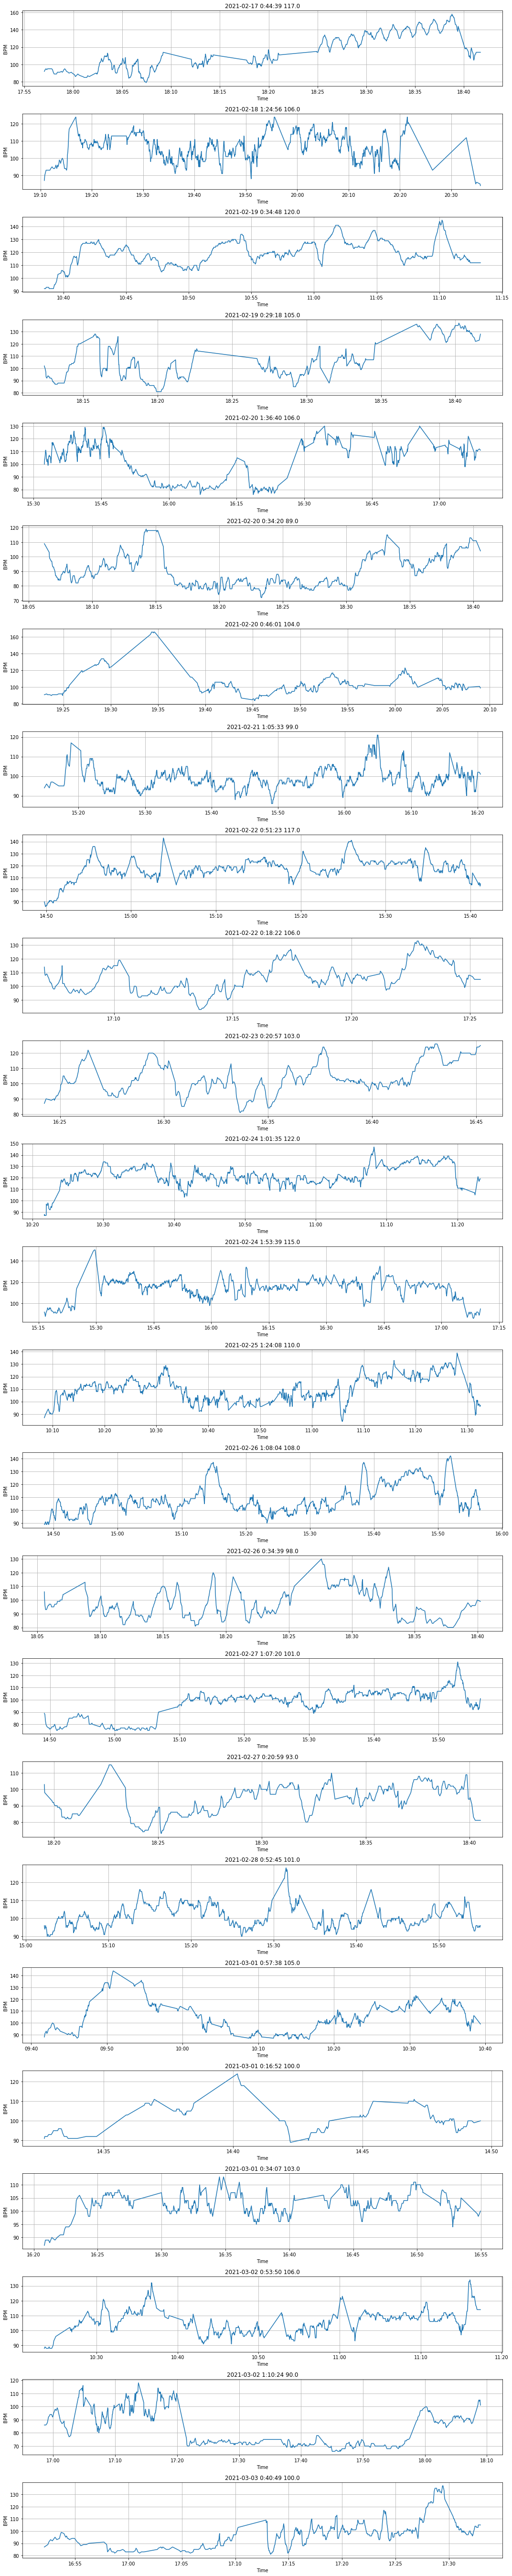

In [18]:
# From: https://matplotlib.org/stable/gallery/lines_bars_and_markers/cohere.html
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

print('nPlots',nPlots)
fig, axs = plt.subplots(nrows=nPlots, ncols=1, figsize=(15, 3*nPlots) )

myFormat = DateFormatter("%H:%M")
register_matplotlib_converters(myFormat)

for i in range(nPlots):
    df=DFs[i]
    #print('Plot i',i)
    axs[i].plot(df['dateTime'], df['BPM'])
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('BPM')
    axs[i].set_title( Summaries[i]['string'] )
    axs[i].grid(True)
    axs[i].xaxis.set_major_formatter(myFormat)
            
fig.tight_layout()
plt.show()